# Project Overview

This project focuses on **text summarization** using two approaches: a traditional **Seq2Seq model** with LSTM and a **Transformer-based model**. The goal is to see how each model performs and understand the difference between step-by-step sequence processing and attention-based processing.

### Steps in the Project
1. **Dataset Preparation**  
   - Load the XSum dataset with articles and summaries.  
   - Tokenize and pad sequences so they can be fed into the models.

2. **Seq2Seq Model (LSTM)**  
   - Build an encoder-decoder model without attention.
   - Train it to generate summaries from the input articles.  

3. **Transformer Model**  
   - Build a Transformer-based encoder-decoder model.  
   - Use self-attention to capture relationships between all tokens.  
   - Train on the same dataset to generate summaries.

4. **Comparison**  
   - Compare the two models using metrics like ROUGE.  
   - Look at differences in summary quality, speed, and how well they handle long sequences.


# Seq2Seq and Encoder-Decoder

## What is a Seq2Seq Model
A sequence-to-sequence (Seq2Seq) model is designed to take an input sequence and produce an output sequence. It’s widely used in tasks like machine translation, text summarization, and chatbots.

**Example:**  
Input: "Hello, how are you?"  
Output: "Ciao, come stai?"

---

## Encoder-Decoder Architecture (Expanded)

A typical Seq2Seq model has two main parts: the **encoder** and the **decoder**. The design allows the model to process sequences of variable length.  

### Encoder
The encoder reads the input sequence and compresses it into a set of hidden states or a context vector. This vector captures the important information from the input and has a fixed size, though it does not need to match the decoder's size. The hidden states can either be passed as a whole to the decoder or connected at every decoding step.  

At each step, the encoder updates its hidden state based on the previous hidden state and the current input. In mathematical terms, for a simple RNN:

$$
H_t^{encoder} = \phi(W_{HH} \cdot H_{t-1}^{encoder} + W_{HX} \cdot X_t)
$$

Where:  
- $H_t^{encoder}$ = hidden state at time $t$ in the encoder  
- $X_t$ = input at time $t$  
- $W_{HH}$ = weight matrix connecting hidden states  
- $W_{HX}$ = weight matrix connecting input to hidden states  
- $\phi$ = activation function (e.g., tanh or ReLU)

---

### Decoder
The decoder generates the output sequence one token at a time. Its initial hidden state is set to the final hidden state of the encoder. For a simple RNN decoder:

$$
H_t^{decoder} = \phi(W_{HH} \cdot H_{t-1}^{decoder} + W_{HY} \cdot Y_{t-1})
$$

The output at each step is computed as:

$$
Y_t = W_{HY} \cdot H_t^{decoder}
$$

Where:  
- $H_t^{decoder}$ = hidden state at time $t$ in the decoder  
- $Y_t$ = output at time $t$  
- $W_{HY}$ = weight matrix connecting decoder hidden state to output  

### Implementation Notes
- Encoders and decoders are typically implemented with **RNNs, LSTMs, or GRUs**.  
- The input and output vectors are of fixed size, but the encoder and decoder can have different hidden dimensions.  
- During training, **teacher forcing** is often used, providing the correct previous token to the decoder instead of its own prediction.  

---

## Tokenization

Before feeding text into a Seq2Seq or Transformer model, the raw text must be converted into numerical form.  
This is done through **tokenization**, which splits text into smaller units (tokens) such as words or subwords.  

Each token is then mapped to a unique integer using a **vocabulary** built from the dataset.  
The model processes these integers rather than the raw text.

**Example:**

Input text: `"Transformers improve summarization."`  
Tokens: `["transformers", "improve", "summarization", "."]`  
Token IDs: `[201, 57, 1342, 4]`

### Why Tokenization Matters
- Converts variable-length text into consistent, model-readable sequences.  
- Helps capture word frequency and context relationships.  
- Reduces vocabulary size when using subword tokenization (e.g., Byte Pair Encoding).  

In this project, tokenization is part of preprocessing and includes:
- **Lowercasing** the text  
- **Removing special characters and URLs**  
- **Splitting into tokens by spaces**  
- Adding **start (`sostok`)** and **end (`eostok`)** tokens to mark summary boundaries  

After tokenization, sequences will later be converted to integer IDs, padded or truncated to a fixed length

---

# Transformers
Transformers can be seen as an evolution of Seq2Seq models. Instead of processing sequences step by step like LSTMs or GRUs, they rely entirely on **attention mechanisms** to process all tokens in parallel and capture relationships between them.

### Attention in Transformers
Attention is the core mechanism that allows Transformers to focus on relevant parts of the input sequence when producing a representation for each token. It works by comparing each token to all others and weighting them according to importance.

#### How Attention Works
Each token in the sequence is represented by three vectors:
- **Query (Q):** what this token is looking for  
- **Key (K):** what information this token contains  
- **Value (V):** the actual information of the token  

The attention score between two tokens is computed as the similarity between the Query of one token and the Key of another. This determines how much attention one token should pay to another. Mathematically, the attention weights are computed using a scaled dot-product:

$$
\text{Attention}(Q, K, V) = \text{softmax}\Big(\frac{QK^T}{\sqrt{d_k}}\Big) V
$$

Where $d_k$ is the dimensionality of the Key vectors.

- The **softmax** ensures that the weights sum to 1.  
- Each token’s output is a weighted sum of all Value vectors, allowing it to incorporate context from the entire sequence.

#### Multi-Head Attention
Instead of computing attention just once, Transformers use **multiple attention heads** in parallel. Each head can learn to focus on different types of relationships, such as:
- Syntactic relationships (e.g., subject-verb connections)  
- Semantic relationships (e.g., synonyms or related concepts)  

The outputs of all heads are concatenated and projected to form the final representation for each token.

#### Intuition
Imagine reading a sentence and highlighting all the words that are important for understanding each token. Each word “attends” to other words in the sentence that matter most for its meaning. Multi-head attention lets the model do this from multiple perspectives simultaneously.

### Key Components of Transformers
- **Encoder-Decoder Structure:** Like Seq2Seq models, Transformers have an encoder that processes the input and a decoder that generates the output. Both use layers of self-attention and feed-forward networks.  
- **Positional Encoding:** Since Transformers don’t process tokens sequentially, they add positional information so the model knows the order of tokens.  
- **Feed-Forward Layers:** After attention, each token passes through fully connected layers for additional transformation.

### Advantages over LSTM/GRU Seq2Seq
- Processes sequences **in parallel**, speeding up training.  
- Handles **long sequences** more effectively with attention.  
- Captures **complex relationships** between tokens regardless of distance.  
- Scales easily to **very deep models** and large datasets.

### Use Cases
Transformers are the backbone of many state-of-the-art models for tasks such as:
- Machine translation (e.g., T5, MarianMT)  
- Text summarization (e.g., BART, Pegasus)  
- Question answering and chatbots (e.g., GPT, BERT-based models)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
!pip install openpyxl

# Data Preparation

Prepare and clean the dataset for the summarization model:

- **Load datasets:** Read two CSV files containing news articles and their summaries.
- **Combine datasets:** Merge datasets while selecting relevant `text` and `summary` columns.
- **Text cleaning:**  
  - Convert text to lowercase.  
  - Remove special characters.  
  - Replace URLs with domain names.  
  - Reduce multiple spaces.
- **Tokenization:** Split cleaned text into tokens (words) and add `_START_` and `_END_` tokens for summaries.
- **Handle missing values:** Drop rows with missing `text` values.
- **Analyze sequence lengths:** Calculate word counts for texts and summaries.
- **Limit sequence lengths:** Restrict `text` to 100 words and `summary` to 15 words.
- **Add model tokens:** Prepend `sostok` and append `eostok` to all summaries to mark start and end for the model.


In [3]:
import pandas as pd
import numpy as np

pd.set_option('display.max_colwidth', None)

summary = pd.read_csv('/kaggle/input/news-summary/news_summary.csv', encoding='iso-8859-1')
summary_more = pd.read_csv('/kaggle/input/news-summary/news_summary_more.csv', encoding='iso-8859-1')
summary_ind = pd.read_excel("/kaggle/input/inshorts-news-data/Inshorts Cleaned Data.xlsx")

print(summary.shape)
print(summary_more.shape)
print(summary_ind.shape)

(4514, 6)
(98401, 2)
(55104, 5)


In [4]:
summary.head(1)

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in offices order,http://www.hindustantimes.com/india-news/rakshabandhan-compulsory-in-daman-and-diu-women-employees-to-tie-rakhis-to-male-colleagues/story-E5h5U1ZDJii5zFpLXWRkhJ.html?utm_source=inshorts&utm_medium=referral&utm_campaign=fullarticle,The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media.,"The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media.The union territory?s administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace.?It has been decided to celebrate the festival of Rakshabandhan on August 7. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues,? the order, issued on August 1 by Gurpreet Singh, deputy secretary (personnel), had said.To ensure that no one skipped office, an attendance report was to be sent to the government the next evening.The two notifications ? one mandating the celebration of Rakshabandhan (left) and the other withdrawing the mandate (right) ? were issued by the Daman and Diu administration a day apart. The circular was withdrawn through a one-line order issued late in the evening by the UT?s department of personnel and administrative reforms.?The circular is ridiculous. There are sensitivities involved. How can the government dictate who I should tie rakhi to? We should maintain the professionalism of a workplace? an official told Hindustan Times earlier in the day. She refused to be identified.The notice was issued on Daman and Diu administrator and former Gujarat home minister Praful Kodabhai Patel?s direction, sources said.Rakshabandhan, a celebration of the bond between brothers and sisters, is one of several Hindu festivities and rituals that are no longer confined of private, family affairs but have become tools to push politic al ideologies.In 2014, the year BJP stormed to power at the Centre, Rashtriya Swayamsevak Sangh (RSS) chief Mohan Bhagwat said the festival had ?national significance? and should be celebrated widely ?to protect Hindu culture and live by the values enshrined in it?. The RSS is the ideological parent of the ruling BJP.Last year, women ministers in the Modi government went to the border areas to celebrate the festival with soldiers. A year before, all cabinet ministers were asked to go to their constituencies for the festival."


In [5]:
summary_more.head(1)

,headlines,text
0,upGrad learner switches to career in ML & Al with 90% salary hike,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."


In [6]:
summary_ind.head(1)

,Headline,Short,Source,Time,Publish Date
0,4 ex-bank officials booked for cheating bank of ₹209 crore,"The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had availed home loans and credit from Syndicate Bank on the basis of forged and fabricated documents. These funds were fraudulently transferred to the companies owned by the accused persons.",The New Indian Express,09:25:00,2017-03-26


In [7]:
summary = summary.iloc[:, 0:6]
summary_more = summary_more.iloc[:, 0:2]

# To increase the intake of possible text values to build a reliable model
summary['text'] = (
    summary['author'] + ' ' +
    summary['date'] + ' ' +
    summary['read_more'] + ' ' +
    summary['text'] + ' ' +
    summary['ctext']
)


df = pd.DataFrame()

df['text'] = pd.concat([summary_more['text'], summary['text'], summary_ind['Short']], ignore_index=True)
df['summary'] = pd.concat([summary_more['headlines'], summary['headlines'], summary_ind['Headline']], ignore_index=True)

df_trans = df

print(df.shape)
df.head(2)

(158019, 2)


,text,summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.",upGrad learner switches to career in ML & Al with 90% salary hike
1,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.",Delhi techie wins free food from Swiggy for one year on CRED


In [8]:
import re

def clean_text(text):
    text = str(text)
    text = re.sub(r'https?://\S+', '', text)  
    text = re.sub(r'\s+', ' ', text).strip()  
    return text


# Tokenization: split text by spaces
def tokenize_texts(texts):
    return [' '.join(clean_text(t).split()) for t in texts]


processed_text = tokenize_texts(df['text'])
#processed_summary = ['_START_ ' + s + ' _END_' for s in tokenize_texts(df['summary'])]
processed_summary = ['sostok ' + s + ' eostok' for s in tokenize_texts(df['summary'])]


df['cleaned_text'] = pd.Series(processed_text)
df['cleaned_summary'] = pd.Series(processed_summary)

In [9]:
print(f"NaN dropped: {df.isna().sum().sum()}")

#df = df.dropna(subset=['text'])
df = df.dropna(subset=['cleaned_text', 'cleaned_summary'])
df = df.drop_duplicates(subset=['cleaned_text', 'cleaned_summary'])

print(df.shape)

NaN dropped: 118
(157638, 4)


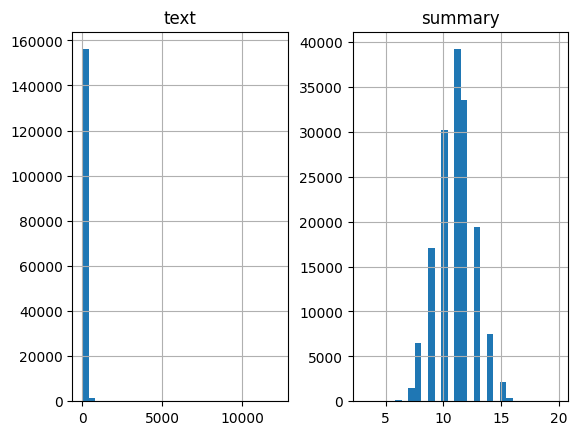

In [10]:
import matplotlib.pyplot as plt

text_count = []
summary_count = []

for sent in df['cleaned_text']:
    text_count.append(len(sent.split()))
    
for sent in df['cleaned_summary']:
    summary_count.append(len(sent.split()))

graph_df = pd.DataFrame() 

graph_df['text'] = text_count
graph_df['summary'] = summary_count

graph_df.hist(bins = 30)
plt.show()

In [11]:
cnt = 0
for i in df['cleaned_text']:
    if len(i.split()) <= 100:
        cnt = cnt + 1
print(f"Percentage of texts with less than 100 words : {cnt / len(df['cleaned_text'])}")

Percentage of texts with less than 100 words : 0.972468567223639


In [12]:
max_text_len = 300
max_summary_len = 20

df['cleaned_text'] = df['cleaned_text'].astype(str)
df['cleaned_summary'] = df['cleaned_summary'].astype(str)

mask = (df['cleaned_text'].str.split().str.len() <= max_text_len) & \
       (df['cleaned_summary'].str.split().str.len() <= max_summary_len)

df = df.loc[mask].reset_index(drop=True)

# Add start and end tokens to each summary
df['cleaned_summary'] = df['cleaned_summary'].apply(lambda x: 'sostok ' + x + ' eostok')

df.head(2)

,text,summary,cleaned_text,cleaned_summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.",upGrad learner switches to career in ML & Al with 90% salary hike,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.",sostok sostok upGrad learner switches to career in ML & Al with 90% salary hike eostok eostok
1,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.",Delhi techie wins free food from Swiggy for one year on CRED,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.",sostok sostok Delhi techie wins free food from Swiggy for one year on CRED eostok eostok


# **Tokenization**

This block prepares the text data for a sequence-to-sequence model:

- **Split dataset**: Separates `text` and `summary` into training and validation sets to evaluate model performance on unseen data.  
- **Initialize tokenizers**: Converts words into integer indices, which neural networks can process.  
- **Analyze rare words**: Computes the percentage of words appearing less than `thresh` times to identify infrequent words that might add noise.  
- **Limit vocabulary to frequent words**: Reduces vocabulary size by ignoring rare words, which improves training efficiency and prevents overfitting.  
- **Convert texts to sequences**: Maps each word in the texts to its corresponding integer index.  
- **Pad sequences**: Ensures all sequences have the same length, necessary for batch processing in neural networks.  
- **Compute final vocabulary size**: Includes the padding token to correctly define the input dimension for the model embedding layer.

In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train, x_val, y_train, y_val = train_test_split(
    np.array(df["cleaned_text"]),
    np.array(df["cleaned_summary"]),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)

x_tokenizer = Tokenizer(oov_token="<unk>") 
x_tokenizer.fit_on_texts(list(x_train))

y_tokenizer = Tokenizer(oov_token="<unk>")   
y_tokenizer.fit_on_texts(list(y_train))

2025-11-13 00:02:53.006381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762992173.184137      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762992173.235429      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [14]:
thresh = 3

def rare_word_stats(tokenizer, thresh):
    """Return total and rare word counts for a given tokenizer."""
    total_cnt = len(tokenizer.word_counts)
    rare_cnt = sum(1 for word, count in tokenizer.word_counts.items() if count < thresh)
    return total_cnt, rare_cnt


x_tot_cnt, x_cnt = rare_word_stats(x_tokenizer, thresh)
y_tot_cnt, y_cnt = rare_word_stats(y_tokenizer, thresh)

print(f"% of rare words in X vocabulary: {(x_cnt / x_tot_cnt) * 100:.2f}%")
print(f"% of rare words in Y vocabulary: {(y_cnt / y_tot_cnt) * 100:.2f}%")

% of rare words in X vocabulary: 57.13%
% of rare words in Y vocabulary: 55.60%


In [15]:
# Create tokenizers considering only frequent words
x_tokenizer = Tokenizer(num_words = x_tot_cnt - x_cnt) 
x_tokenizer.fit_on_texts(list(x_train))

y_tokenizer = Tokenizer(num_words=y_tot_cnt-y_cnt) 
y_tokenizer.fit_on_texts(list(y_train))

# Convert text to sequences of integers
x_train_seq = x_tokenizer.texts_to_sequences(x_train) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

y_train_seq = y_tokenizer.texts_to_sequences(y_train) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

# Pad sequences
x_train = pad_sequences(x_train_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

y_train = pad_sequences(y_train_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

# Vocab. size (+1 for padding token)
x_voc_size = x_tokenizer.num_words + 1
y_voc_size = y_tokenizer.num_words + 1

print(f"Size of vocabulary in X = {x_voc_size}")
print(f"Size of vocabulary in Y = {y_voc_size}")

Size of vocabulary in X = 54581
Size of vocabulary in Y = 22980


In [16]:
# Finally remove from the dataset empty summaries that contain only the 'START' and 'END' tokens

x_train = x_train[np.sum(y_train != 0, axis=1) > 2]
y_train = y_train[np.sum(y_train != 0, axis=1) > 2]

x_val = x_val[np.sum(y_val != 0, axis=1) > 2]
y_val = y_val[np.sum(y_val != 0, axis=1) > 2]

# **Seq2seq model using LSTM**

### Encoder-Decoder Architecture with LSTM

During training, the model takes **two inputs**:  
1. The encoder input (`text`) – the original text sequence.  
2. The decoder input (`summary`) – the summary shifted by one token (so that the model learns to predict the next word).  

The **target output** is the summary sequence shifted forward by one token. The model learns to predict the next word in the summary based on the previous words. During inference, the trained model generates summaries one word at a time, using the previously predicted words as input.

---

**Encoder**  
- The encoder accepts sequences of text with a fixed length (`max_text_len`).  
- The text is first passed through an **Embedding layer** that maps each word index to a dense vector of size `(embedding_dim)`.  
- The embedded sequence is then processed by **three stacked LSTM layers**:  
  - Each layer outputs the **full sequence of hidden states** (for possible attention or stacking) and the **last hidden and cell states**.  
  - The last hidden and cell states from the final LSTM are used to initialize the decoder.  
- Stacking multiple LSTMs allows the encoder to **capture both local patterns and long-range dependencies** in the text.

---

**Decoder**  
- The decoder input (shifted summary) is passed through an **Embedding layer** of size `(summary vocabulary size x embedding_dim)`.  
- A single **LSTM** processes the embedded sequence, using the **encoder's last hidden and cell states** as its initial state.  
- The LSTM output is passed through a **TimeDistributed Dense layer** with **softmax activation**, which predicts the probability of each word in the vocabulary at each time step.  

This architecture ensures that the decoder can generate the summary step by step, **learning the sequence of words conditioned on the input text**.


In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

latent_dim = 300
embedding_dim = 200

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb = Embedding(x_voc_size, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Decoder
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc_size, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

I0000 00:00:1762992209.555406      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 300, 200)  │ 10,916,200 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 300,      │    601,200 │ embedding[0][0]   │
│                     │ 300), (None,      │            │                   │
│                     │ 300), (None,      │            │                   │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 300,      │    721,200 │ lstm[0][0]        │
│                     │ 300), (None,      │            │                   │
│                     │ 300), (None,      │            │                   │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 200) │  4,596,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 300,      │    721,200 │ lstm_1[0][0]      │
│                     │ 300), (None,      │            │                   │
│                     │ 300), (None,      │            │                   │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │    601,200 │ embedding_1[0][0… │
│                     │ 300), (None,      │            │ lstm_2[0][1],     │
│                     │ 300), (None,      │            │ lstm_2[0][2]      │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None,      │  6,916,980 │ lstm_3[0][0]      │
│ (TimeDistributed)   │ 22980)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,073,980 (95.65 MB)

 Trainable params: 25,073,980 (95.65 MB)

 Non-trainable params: 0 (0.00 B)

## **Training the model** 

In [18]:
x_train_lstm = x_train
x_val_lstm = x_val
y_train_lstm = y_train
y_val_lstm = y_val

MODEL_INPUT_PATH = "/kaggle/input/lstm-keras-summarization/keras/default/1/model_lstm.keras" 
MODEL_PATH = "/kaggle/working/model_lstm.keras" 

# retrain the model
if os.path.exists(MODEL_INPUT_PATH):
    model = load_model(MODEL_INPUT_PATH)

else:
    model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

    history = model.fit(
        [x_train, y_train[:, :-1]],
        y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:, 1:],
        epochs=50,
        callbacks=[es],
        batch_size=128,
        validation_data=(
            [x_val, y_val[:, :-1]],
            y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]
        )
    )

    model.save(MODEL_PATH)

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 22 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## **Predict**

Once the Seq2Seq model has been trained, we can use it to **generate summaries** for new input texts.  
This stage is known as **inference**, the model no longer learns, but uses its learned parameters to predict the most likely output sequence (summary).

---

### 1. Preparing the Mapping Dictionaries
Before generating predictions, we rebuild the word–token mappings from the tokenizers:
- `reverse_x_word_index`: converts article tokens → words  
- `reverse_y_word_index`: converts summary tokens → words  
- `y_word_index`: converts summary words → tokens  

These dictionaries let us translate between the model’s numeric predictions and readable text.

---

### 2. Building Inference Models
During training, the encoder and decoder work together in a single model.  
At inference time, we separate them:

- The **encoder model** processes the input text once and produces context vectors (`encoder_outputs`, `state_h`, `state_c`) — a compressed representation of the input.  
- The **decoder model** generates the summary **one word at a time**, taking as input the previous word and its previous internal states.

This setup allows the decoder to iteratively predict each next token until the end-of-sequence marker (`eostok`) is reached.

---

### 3. The Decoding Process
The function `decode_sequence()` handles the actual text generation:

1. **Encode the input sequence** using the encoder model to obtain its internal states.  
2. **Initialize** the decoder with the special start token (`sostok`).  
3. **Iteratively predict** the next word:
   - Feed the previous word and the latest decoder states into the model.
   - Pick the word with the highest probability (`argmax`).
   - Stop when the `eostok` token is predicted or the maximum summary length is reached.
4. **Concatenate** all predicted tokens into a readable summary.

This process simulates how the model “writes” one word at a time, using its internal memory to maintain context.

---

### 4. Converting Sequences to Text
Two helper functions make the predictions human-readable:
- `seq2text()` converts numeric article sequences back into words.
- `seq2summary()` converts numeric summary sequences back into words, excluding special tokens (`sostok`, `eostok`).


In [19]:
# reverse_y_word_index: summary token → word
# reverse_x_word_index: article token → word
# y_word_index: summary word → token

reverse_y_word_index = y_tokenizer.index_word
reverse_x_word_index = x_tokenizer.index_word
y_word_index = y_tokenizer.word_index

In [20]:
# Inference Models
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
# decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
#                       decoder_state_input_h, decoder_state_input_c],
#                       [decoder_outputs2] + [state_h2, state_c2])
#TPU error
decoder_model = Model(
    [decoder_inputs, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2, state_h2, state_c2]
)


In [21]:
# Convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != y_word_index['sostok'] and i \
            != y_word_index['eostok']:
            newString = newString + reverse_y_word_index[i] + ' '

    return newString

# Convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_x_word_index[i] + ' '

    return newString

def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq, verbose=0)

    # Generate empty target sequence of length 1
    y_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    y_seq[0, 0] = y_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([y_seq]
                + [e_out, e_h, e_c], verbose=0)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_y_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) \
            >= max_summary_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        y_seq = np.zeros((1, 1))
        y_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [22]:
# for i in range(0, 5):
#     print ('Review:', seq2text(x_train[i]))
#     print ('Original summary:', seq2summary(y_train[i]))
#     print ('Predicted summary:', decode_sequence(x_train[i].reshape(1, max_text_len)))
#     print('\n')

# Transformer Model with Self-Attention

Similar to the Seq2Seq architecture, the Transformer follows an **encoder–decoder structure**, but instead of recurrent layers it relies entirely on **Multi-Head Self-Attention**.  
This allows the model to process all tokens **in parallel** and learn relationships between words regardless of their distance in the sequence.

During training, the model takes **two inputs**:  
1. The encoder input (`text`) – the tokenized article.  
2. The decoder input (`summary`) – the summary shifted by one token.  

The **target output** is the summary shifted forward by one position. The decoder learns to predict each word based on the previously generated ones and the encoded representation of the full text.

---

**Encoder**  
- The input article sequence (`max_text_len`) is first transformed using an **Embedding layer**.  
- A **Positional Encoding** is added to preserve the order of words (since attention has no notion of sequence order by itself).  
- The embedded input is processed by one or more **Multi-Head Self-Attention** blocks:
  - Each word attends to **all other words** in the input
  - Relationships between distant tokens are captured more effectively than in RNNs  
- A **Feed-Forward Network** (FFN) refines the contextual representations.
- **Residual connections** and **Layer Normalization** improve gradient flow and training stability.

---

**Decoder**  
- Similar positional embeddings are applied to the shifted summary tokens.  
- The decoder uses two attention mechanisms:
  1. **Masked Self-Attention**: ensures the model cannot “peek” at future words when predicting the next token.
  2. **Encoder-Decoder Attention**: allows the decoder to focus on relevant parts of the input article.
- A **Feed-Forward Network** further processes the attended features.
- A final **Dense layer with Softmax** outputs a probability distribution over all words in the vocabulary at each time step.

---

**sostok and eostok**  
In sequence-to-sequence tasks such as abstractive text summarization, **special tokens** are essential for controlling how a model generates text:

- `<sostok>` → marks the **start** of the output sequence  
- `<eostok>` → marks the **end** of the sequence  

However, these tokens **do not** play the same role during training across different architectures.

Transformers use **masked self-attention** in the decoder, meaning that at time *t* the model can only attend to **previous tokens**.
Therefore:

- `<sostok>` must be present **only in the decoder input**  
- `<sostok>` must be removed from the decoder target  

Predicting a start token would make no sense and causes failure modes such as:

- the model repeatedly outputting `<sostok>`
- inability to begin sequences with meaningful content

The EOS token **must remain in the targets**, because:

- it teaches the model **when to stop writing**
- without it, generation may become too long or infinite

LSTM encoder-decoder models:

- receive the final hidden state as initial context
- do **not** use masked attention
- often ignore the first timestep in loss computation

So `<sostok>` in targets is less harmful there.

---

Thanks to the Self-Attention mechanism, Transformers **capture global context efficiently** and typically produce **more coherent and fluent summaries**, especially for longer texts.

### Preparing Transformer Inputs

To train the Transformer in an encoder–decoder setup, we need to properly structure the input data:

- The **encoder input** is the full tokenized article (`x_train`)
- The **decoder input** is the summary sequence **shifted right**, starting with `<sostok>`
- The **decoder target** is the same summary **shifted left**, ending with `<eostok>`

This shifting ensures that at each timestep the decoder learns to predict the **next** word using:
1. The previously processed summary tokens  
2. Attention over the encoder output  

In text summarization, token-level accuracy can be misleading because it only measures whether each predicted token matches the ground truth at the same position. It does not capture semantic meaning, fluency, word order, or relevance, and it can be inflated by common tokens like padding or start/end markers. A model can have high accuracy while producing poor summaries. Better evaluation uses metrics like ROUGE-1, ROUGE-2, and ROUGE-L, which measure overlap of unigrams, bigrams, and longest common subsequences between generated and reference summaries. During training, it is better to monitor validation loss and evaluate summaries qualitatively or with ROUGE rather than relying on token accuracy.

## Predict

Note importanti:

Look-ahead mask a inference non serve se generi un token alla volta (greedy decoding step-by-step).

Padding mask dell’encoder serve al decoder per ignorare i pad token dell’input.

Quando fai l’inference dovrai generare token uno per uno, aggiornando dec_input_inf ad ogni step.

Generated summary: ripete continuamente parole (cannot cannot cannot, power power power…) → questo è un loop di ripetizione, tipico dei modelli seq2seq che non hanno abbastanza regolarizzazione sulla generazione.

Generated beam search summary: testo quasi completamente fuori tema → indica che il modello non ha appreso bene il contenuto semantico e il beam search amplifica le frasi che appaiono più “probabili” a livello di token, ma non corrette.


In [23]:
df_trans.head(1)
df_tmp = df_trans

In [24]:
import tensorflow as tf

f_trans = df_tmp

# Data processing
df_trans['cleaned_text'] = df_trans['text'].apply(clean_text)
df_trans['cleaned_summary'] = df_trans['summary'].apply(clean_text)

df_trans = df_trans.dropna(subset=['cleaned_text', 'cleaned_summary'])
df_trans = df_trans.drop_duplicates(subset=['cleaned_text', 'cleaned_summary'])

#df_trans['cleaned_summary'] = df_trans['cleaned_summary'].apply(lambda x: '<SOS> ' + x + ' <EOS>')
df_trans['cleaned_summary'] = df_trans['cleaned_summary'].apply(lambda x: '<SOS> ' + x.strip() + ' <EOS>')

mask = (df_trans['cleaned_text'].str.split().str.len() <= max_text_len) & \
       (df_trans['cleaned_summary'].str.split().str.len() <= max_summary_len)
df_trans = df_trans.loc[mask].reset_index(drop=True)

# Tokenizer
oov_token = '<unk>'
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'

max_vocab_text = 40000
max_vocab_summary = 20000

x_tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=max_vocab_text, 
    oov_token=oov_token, 
    filters=filters, 
    lower=True
)
x_tokenizer.fit_on_texts(df_trans['cleaned_text'])

y_tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=max_vocab_summary, 
    oov_token=oov_token, 
    filters=filters, 
    lower=True
)
y_tokenizer.fit_on_texts(df_trans['cleaned_summary'])

inputs = x_tokenizer.texts_to_sequences(df_trans['cleaned_text'])
targets = y_tokenizer.texts_to_sequences(df_trans['cleaned_summary'])

# Padding
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=max_text_len, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=max_summary_len, padding='post', truncating='post')

inputs = tf.cast(inputs, dtype=tf.int64)
targets = tf.cast(targets, dtype=tf.int64)

# Vocab. size (+1 for padding token)
x_voc_size = min(max_vocab_text, len(x_tokenizer.word_index) + 1)
y_voc_size = min(max_vocab_summary, len(y_tokenizer.word_index) + 1)

print(f"Size of vocabulary in X = {x_voc_size}")
print(f"Size of vocabulary in Y = {y_voc_size}")

Size of vocabulary in X = 40000
Size of vocabulary in Y = 20000


In [25]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(10000).batch(64)

def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    #dk = tf.cast(tf.shape(k)[-1], tf.float32)
    dk = tf.cast(tf.shape(k)[-1], q.dtype)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights
    
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])


class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training=False, mask=None):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
    
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
    
        return out2



class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training=False, look_ahead_mask=None, padding_mask=None):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
    
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
    
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
    
        return out3, attn_weights_block1, attn_weights_block2



class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training=False, mask=None):
        seq_len = tf.shape(x)[1]
    
        x = self.embedding(x)
        #x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # x += self.pos_encoding[:, :seq_len, :]
        x *= tf.math.sqrt(tf.cast(self.d_model, x.dtype)) 
        x += tf.cast(self.pos_encoding[:, :seq_len, :], x.dtype)

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)
    
        return x
    
class Decoder(tf.keras.layers.Layer):
        
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training=False, look_ahead_mask=None, padding_mask=None):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
    
        x = self.embedding(x)
        #x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        #x += self.pos_encoding[:, :seq_len, :]
        x *= tf.math.sqrt(tf.cast(self.d_model, x.dtype))              
        x += tf.cast(self.pos_encoding[:, :seq_len, :], x.dtype)      

    
        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](
                x, 
                enc_output, 
                training=training, 
                look_ahead_mask=look_ahead_mask, 
                padding_mask=padding_mask
            )
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2
    
        return x, attention_weights




class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training=False, enc_padding_mask=None, look_ahead_mask=None, dec_padding_mask=None):
        enc_output = self.encoder(x=inp, training=training, mask=enc_padding_mask)
        dec_output, attention_weights = self.decoder(x=tar, enc_output=enc_output, training=training, look_ahead_mask=look_ahead_mask, padding_mask=dec_padding_mask)
        final_output = self.final_layer(dec_output)
        return final_output, attention_weights

In [26]:
num_layers = 4
d_model = 256
dff = 1024
num_heads = 8
dropout_rate = 0.2

# num_layers = 2
# d_model = 64
# dff = 256
# num_heads = 2
# dropout_rate = 0.1


class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        step = tf.cast(step, tf.float32) 
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)



learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [27]:
import time

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    #accuracies = tf.cast(accuracies, dtype= tf.float32)

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [28]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=x_voc_size,
    target_vocab_size=y_voc_size,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate
)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')


checkpoint_path = "/kaggle/working/checkpoints" 

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if ckpt_manager.latest_checkpoint:
#     ckpt.restore(ckpt_manager.latest_checkpoint)
#     print(f'Checkpoint restored from {ckpt_manager.latest_checkpoint}')



dummy_input = tf.constant([[1]*max_text_len], dtype=tf.int64)
dummy_target = tf.constant([[1]*max_summary_len], dtype=tf.int64)
pred, _ = transformer(dummy_input, dummy_target, training=False)
transformer.summary()


"""
ckpt = tf.train.Checkpoint(transformer=transformer)
ckpt.restore("/kaggle/input/trans-chpt30/ckpt-30").assert_existing_objects_matched()
print("Checkpoint restored")
"""


@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, 
            tar_inp, 
            training=True, 
            enc_padding_mask=enc_padding_mask, 
            look_ahead_mask=combined_mask, 
            dec_padding_mask=dec_padding_mask
        )


        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss.update_state(loss)
    train_accuracy.update_state(accuracy_function(tar_real, predictions))

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ ?                      │    13,399,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ ?                      │     9,333,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (1, 20, 20000)         │     5,140,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,872,800 (106.33 MB)

 Trainable params: 27,872,800 (106.33 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
patience = 3  
best_loss = float('inf')
wait = 0
EPOCHS = 2

for epoch in range(EPOCHS):
    start = time.time()
    train_loss.reset_state()
    train_accuracy.reset_state()


    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
      
    current_loss = train_loss.result()
    
    if current_loss < best_loss:
        best_loss = current_loss
        wait = 0
        ckpt_save_path = ckpt_manager.save()
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    print(f'Epoch {epoch + 1} Accuracy {train_accuracy.result():.4f} Loss {current_loss:.4f} Time {time.time() - start:.2f} seconds\n')


/usr/local/lib/python3.11/dist-packages/tensorflow/python/util/numpy_compat.py:47: RuntimeWarning: overflow encountered in cast
  return np.array(values, copy=copy, order=order).astype(dtype)


Epoch 1 Accuracy 0.0000 Loss nan Time 671.02 seconds

Epoch 2 Accuracy 0.0000 Loss nan Time 621.42 seconds



In [30]:
def summarize(input_article, beam_width=3):
    input_article = x_tokenizer.texts_to_sequences([input_article])
    input_article = tf.keras.preprocessing.sequence.pad_sequences(
        input_article, maxlen=max_text_len, padding='post', truncating='post')
    encoder_input = tf.expand_dims(input_article[0], 0)

    sequences = [([y_tokenizer.word_index['<sos>']], 0.0)]

    completed_sequences = []

    for _ in range(max_summary_len):
        all_candidates = []
        for seq, score in sequences:
            if seq[-1] == y_tokenizer.word_index['<eos>']:
                completed_sequences.append((seq, score))
                continue

            output = tf.expand_dims(seq, 0)
            enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

            predictions, _ = transformer(
                encoder_input, 
                output,
                training=False,
                enc_padding_mask=enc_padding_mask,
                look_ahead_mask=combined_mask,
                dec_padding_mask=dec_padding_mask
            )

            logits = predictions[:, -1, :]
            log_probs = tf.math.log(tf.nn.softmax(logits))
            top_k = tf.math.top_k(log_probs, k=beam_width)

            for i in range(beam_width):
                token = int(top_k.indices[0, i])
                candidate_score = score + float(top_k.values[0, i])
                candidate_seq = seq + [token]
                all_candidates.append((candidate_seq, candidate_score))

        sequences = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)[:beam_width]

        if not sequences:
            break

    completed_sequences.extend(sequences)
    best_seq = max(completed_sequences, key=lambda tup: tup[1])[0]

    return y_tokenizer.sequences_to_texts([best_seq])[0]

In [31]:
for i in range(10):
    text = df_trans['cleaned_text'][i]
    real_summary = df_trans['cleaned_summary'][i]
    print(f"\nText : {text} \nReal Headline : {real_summary} \nSummary : {summarize(text)}")


Text : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers. 
Real Headline : <SOS> upGrad learner switches to career in ML & Al with 90% salary hike <EOS> 
Summary : <sos> dna dna dna dna dna dna dna dna dna dna dna dna dna dna dna dna dna dna dna dna

Text : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more. 
Real Headline : <SOS> Delhi techie wins free food from Swiggy for o

# Credits

- **"Implementing Seq2Seq Models for Text Summarization With Keras"**  
  *by Samhita Alla* 